In [2]:
import pandas as pd
import numpy as np

In [3]:
DiabetesTakingMed = pd.read_csv('DiabetesTakingMed.csv', index_col=0)

In [4]:
DiabetesTrain3 = DiabetesTakingMed[DiabetesTakingMed['IsTrain']==1].drop('IsTrain', axis=1)
DiabetesTrain3.index = list(range(len(DiabetesTrain3)))

DiabetesTest3 = DiabetesTakingMed[DiabetesTakingMed['IsTrain']==0].drop('IsTrain', axis=1)
DiabetesTest3.index = list(range(len(DiabetesTest3)))

trainX3 = DiabetesTrain3.drop('readmitted', axis=1)
trainY3 = DiabetesTrain3['readmitted'].replace([2, 1], [1, 0])

testX3 = DiabetesTest3.drop('readmitted', axis=1)
testY3 = DiabetesTest3['readmitted'].replace([2, 1], [1, 0])

In [5]:
#Import and run the model:
import xgboost
from xgboost.sklearn import XGBClassifier as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score as AUC

In [6]:
'''xgb = xgb()

params = {
        'n_estimators':[200, 400, 600, 800, 1000],
        'min_child_weight': [1, 2, 5, 10],
        'gamma': [0.1, 0.2, 0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 3, 5, 8]
        }

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=6, 
                                   cv=4, verbose=5, random_state=42)

random_search.fit(trainX2, trainY2)

random_search.best_params_'''

print("n_estimators=200, min_child_Weight=10, max_depth=5, gamma=5, colsample_bytree=0.6")

n_estimators=200, min_child_Weight=10, max_depth=5, gamma=5, colsample_bytree=0.6


In [7]:
from xgboost.sklearn import XGBClassifier as xgb

xgbF = xgb()
xgbF.set_params(n_estimators=200, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6)

xgbF.fit(trainX3, trainY3)

predict = xgbF.predict(testX3)
predictprobs = xgbF.predict_proba(testX3)

#Make feature importances list:
AnyChangeXGBFeatures = pd.DataFrame({'Feature':pd.Series(trainX3.columns), 'Importance':xgbF.feature_importances_})

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
predictprobs

array([[0.92972445, 0.07027554],
       [0.9098509 , 0.09014908],
       [0.8505523 , 0.1494477 ],
       ...,
       [0.9491745 , 0.05082546],
       [0.9068813 , 0.09311873],
       [0.9207904 , 0.07920964]], dtype=float32)

In [9]:
#0.673 better than the 0.66 we had with other methods.
AUC(testY3, predictprobs[:,1])

0.6749736534379563

In [10]:
from sklearn.metrics import brier_score_loss as BSL

#0.0956 for XGBoost lower than the stack of logistic and RF (0.09589)
BSL(testY3, predictprobs[:,1])

0.09557876216512425

In [11]:
'''#Let's randomsearch for additional parameters:

xgbG = xgb()
xgbG.set_params(n_estimators=200, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6)

params2 = {
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'max_delta_step': [0, 1, 2, 5, 8],
        'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
        }

random_search2 = RandomizedSearchCV(xgbG, param_distributions=params2, n_iter=60, scoring='roc_auc', n_jobs=6, 
                                   cv=4, verbose=5, random_state=42)

random_search2.fit(trainX2, trainY2)

random_search2.best_params_'''

print("subsample=1, max_delta_step=5, learning_rate=0.1")

subsample=1, max_delta_step=5, learning_rate=0.1


In [12]:
xgbF2 = xgb()
xgbF2.set_params(n_estimators=200, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, max_delta_step=5)

xgbF2.fit(trainX3, trainY3)

predict = xgbF2.predict(testX3)
predictprobs = xgbF2.predict_proba(testX3)

#Make feature importances list:
AnyChangeXGBFeatures = pd.DataFrame({'Feature':pd.Series(trainX3.columns), 'Importance':xgbF2.feature_importances_})

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [13]:
#This is literally the same AUC score. It would seem that not a simgle tree had an altered prediction.
AUC(testY3, predictprobs[:,1])

0.6749736534379563

In [14]:
AnyChangeXGBFeatures.sort_values('Importance', ascending=False)
ChoiceColumns = list(AnyChangeXGBFeatures[AnyChangeXGBFeatures['Importance']>0]['Feature'])

In [15]:
trainX3C = trainX3[ChoiceColumns]
testX3C = testX3[ChoiceColumns]

xgbF2C = xgb()
xgbF2C.set_params(n_estimators=500, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, max_delta_step=5)

xgbF2C.fit(trainX3, trainY3)

predictC = xgbF2C.predict(testX3)
predictprobsC = xgbF2C.predict_proba(testX3)

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
#I also raised N_estimators as there is rarely a penalty for doing this, and it helped raise test AUC.
AUC(testY3, predictprobsC[:,1])

0.6753665800254492

In [19]:
from sklearn.metrics import brier_score_loss as BSL

BSL(testY3, predictprobsC[:,1])

0.09555372008645409

In [ ]:
#Summary: XGB: 0.6754, 0.09555

In [18]:
from sklearn.ensemble import RandomForestClassifier as rfc

rfc = rfc()
rfc.set_params(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=60)

rfc.fit(trainX3, trainY3)
predictprobs = rfc.predict_proba(trainX3)
predictvalues = rfc.predict(trainX3)
actual = trainY3.values

R2 = rfc.score(trainX3, trainY3)
#Run a test on the completely untouched test 20%
TestR2 = rfc.score(testX3, testY3)

predicttestRF = rfc.predict(testX3)
predicttestprobsRF = rfc.predict_proba(testX3)

In [21]:
AUC(testY3, predicttestprobsRF[:,1])

0.6542464474137797

In [24]:
BSL(testY3, predicttestprobsRF[:,1])

0.09661379921141608

In [25]:
#Summary:  XGB: 0.6754, 0.09555
#           RF: 0.6542, 0.09661

In [26]:
from sklearn.linear_model import LogisticRegression as lgr

lgr = lgr()
lgr.set_params(C=0.1)

lgr.fit(trainX3, trainY3)
predictprobs = lgr.predict_proba(trainX3)
predictvalues = lgr.predict(trainX3)
actual = trainY3.values

R2 = lgr.score(trainX3, trainY3)
#Run a test on the completely untouched test 20%
TestR2 = lgr.score(testX3, testY3)

predicttestLR = lgr.predict(testX3)
predicttestprobsLR = lgr.predict_proba(testX3)

In [27]:
AUC(testY3, predicttestprobsLR[:,1])

0.6633660039876829

In [29]:
BSL(testY3, predicttestprobsLR[:,1])

0.09661711502693517

In [30]:
#Summary:  XGB: 0.6754, 0.09555
#           RF: 0.6542, 0.09661
#     Logistic: 0.6634, 0.09662

In [31]:
Stack = predictprobsC[:,1]/3 + predicttestprobsRF[:,1]/3 + predicttestprobsLR[:,1]/3
AUC(testY3, Stack)

0.6740965918038246

In [33]:
Stack2 = predictprobsC[:,1]/2 + predicttestprobsLR[:,1]/2

In [34]:
AUC(testY3, Stack2)

0.6747721319613459

In [36]:
#We can write a function to find a candidate feature list using AIC engineering:

def FindLowestAICNonLogBackward(df, dependent):
    '''Input: DF to AIC-modify and the dependent variable. WILL RETURN: A tuple: [0] is the modified DF (with dependent)
    and tuple[1] will give you the summary DF'''
    df2 = df.copy()
    df2X = df2.drop(dependent, axis=1)
    df2Y = df2[dependent]
    FeatureList = list(df2X.columns)
    X2 = sm.add_constant(df2X)
    est = sm.OLS(df2Y, X2)
    CurrentAIC = est.fit().aic
    CanBeBetter = True
    ModList = []
    AddedSubtracted = []
    AIC = []
    TriesSinceReset = 0
    
    tempColumnList = list(df2X.columns)
    tempDF2X = df2X[tempColumnList]
    
    while CanBeBetter == True:
        Choice = np.random.choice(list(df2X.columns))
        
        HeadsTails = np.random.randint(2)
        if Choice in tempColumnList:
            HeadsTails = 0
        if Choice not in tempColumnList:
            HeadsTails = 1
        
        if HeadsTails == 1:
            tempColumnList.append(Choice)
            tempDF2X[Choice] = df2X[Choice]
        
        if HeadsTails == 0:

            tempColumnList.remove(Choice)
            tempDF2X = tempDF2X[tempColumnList]
            
        est = sm.OLS(df2Y, sm.add_constant(tempDF2X))
        NewAIC = est.fit().aic
        
        if NewAIC < CurrentAIC:
            TriesSinceReset = 0
            CurrentAIC = NewAIC
            
            if HeadsTails == 1:
                print(Choice + " added: New AIC = " + str(CurrentAIC))
                ModList.append(Choice)
                AddedSubtracted.append('Added')
                AIC.append(CurrentAIC)
                
            if HeadsTails == 0:
                print(Choice + " removed: New AIC = " + str(CurrentAIC))
                ModList.append(Choice)
                AddedSubtracted.append('Subtracted')
                AIC.append(CurrentAIC)
            continue
            
        else:
            TriesSinceReset += 1
            
            if HeadsTails == 1:
                tempColumnList.remove(Choice)
                tempDF2X = tempDF2X[tempColumnList]
                
            if HeadsTails == 0:
                tempColumnList.append(Choice)
                tempDF2X[Choice] = df2X[Choice]
                
            if TriesSinceReset > 100:
                CanBeBetter = False
                
    SummaryDF = pd.DataFrame({'Feature': ModList, 'AddOrSubtract': AddedSubtracted, 'AIC': AIC})
    NewDF = pd.concat([tempDF2X, df2[[dependent]]], axis=1)
    
    return NewDF, SummaryDF

In [38]:
import statsmodels.api as sm

DiabetesTakingMed = pd.read_csv('DiabetesTakingMed.csv', index_col=0)
DiabetesTrain3 = DiabetesTakingMed[DiabetesTakingMed['IsTrain']==1].drop('IsTrain', axis=1)
DiabetesTrain3.index = list(range(len(DiabetesTrain3)))

DiabetesAICTest01 = FindLowestAICNonLogBackward(DiabetesTrain3, 'readmitted')

med_nateglinide removed: New AIC = 159715.59739305108
med_glimepiride removed: New AIC = 159714.7314944843
diag_injury removed: New AIC = 159713.04955270758
med_glipizide.metformin removed: New AIC = 159711.19338007295
med_glyburide.metformin removed: New AIC = 159709.48548520193
diag_nan removed: New AIC = 159707.58361580828
diag_infection removed: New AIC = 159707.17721194788
max_glu_serum_>200 removed: New AIC = 159705.39239771228
med_chlorpropamide removed: New AIC = 159703.39311154024
admission_type_id_3 removed: New AIC = 159701.60665614
diag_blooddis removed: New AIC = 159700.3146857473
diag_urogenital removed: New AIC = 159698.40742849838
admission_type_id_4 removed: New AIC = 159696.6744639213
diabfeat_hyperosmolarity removed: New AIC = 159695.31432077044
med_miglitol removed: New AIC = 159694.51859519398
med_tolazamide removed: New AIC = 159693.06082870622
race_AfricanAmerican removed: New AIC = 159691.99226043737
med_glyburide removed: New AIC = 159690.25691047826
discharge_

In [42]:
DiabetesTrain3Cut = DiabetesTrain3[list(DiabetesAICTest01[0].columns)]
DiabetesTest3Cut = DiabetesTest3[list(DiabetesAICTest01[0].columns)]

In [43]:
from sklearn.linear_model import LogisticRegression as lgr

lgr = lgr()
lgr.set_params(C=0.1)

trainX3 = DiabetesTrain3Cut.drop('readmitted', axis=1)
trainY3 = DiabetesTrain3Cut['readmitted'].replace([2, 1], [1, 0])

testX3 = DiabetesTest3Cut.drop('readmitted', axis=1)
testY3 = DiabetesTest3Cut['readmitted'].replace([2, 1], [1, 0])

lgr.fit(trainX3, trainY3)
predictprobs = lgr.predict_proba(trainX3)
predictvalues = lgr.predict(trainX3)
actual = trainY3.values

R2 = lgr.score(trainX3, trainY3)
#Run a test on the completely untouched test 20%
TestR2 = lgr.score(testX3, testY3)

predicttestLR = lgr.predict(testX3)
predicttestprobsLR = lgr.predict_proba(testX3)

In [44]:
AUC(testY3, predicttestprobsLR[:,1])

0.6616445605479241

In [45]:
from sklearn.linear_model import LogisticRegression as lgr

lgr = lgr()
lgr.set_params(C=0.1)

trainX3 = DiabetesTrain3.drop('readmitted', axis=1)
trainY3 = DiabetesTrain3['readmitted'].replace([2, 1], [1, 0])

testX3 = DiabetesTest3.drop('readmitted', axis=1)
testY3 = DiabetesTest3['readmitted'].replace([2, 1], [1, 0])

lgr.fit(trainX3, trainY3)
predictprobs = lgr.predict_proba(trainX3)
predictvalues = lgr.predict(trainX3)
actual = trainY3.values

R2 = lgr.score(trainX3, trainY3)
#Run a test on the completely untouched test 20%
TestR2 = lgr.score(testX3, testY3)

predicttestLR = lgr.predict(testX3)
predicttestprobsLR = lgr.predict_proba(testX3)

In [46]:
AUC(testY3, predicttestprobsLR[:,1])

0.6633660039876829

In [47]:
from sklearn.ensemble import RandomForestClassifier as rfc

DiabetesTrain3 = DiabetesTakingMed[DiabetesTakingMed['IsTrain']==1].drop('IsTrain', axis=1)
DiabetesTrain3.index = list(range(len(DiabetesTrain3)))

DiabetesTest3 = DiabetesTakingMed[DiabetesTakingMed['IsTrain']==0].drop('IsTrain', axis=1)
DiabetesTest3.index = list(range(len(DiabetesTest3)))

trainX3 = DiabetesTrain3.drop('readmitted', axis=1)
trainY3 = DiabetesTrain3['readmitted'].replace([2, 1], [1, 0])

testX3 = DiabetesTest3.drop('readmitted', axis=1)
testY3 = DiabetesTest3['readmitted'].replace([2, 1], [1, 0])

rfc = rfc()
rfc.set_params(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=60)

rfc.fit(trainX3, trainY3)
predictprobs = rfc.predict_proba(trainX3)
predictvalues = rfc.predict(trainX3)
actual = trainY3.values

R2 = rfc.score(trainX3, trainY3)
#Run a test on the completely untouched test 20%
TestR2 = rfc.score(testX3, testY3)

predicttestRF = rfc.predict(testX3)
predicttestprobsRF = rfc.predict_proba(testX3)

In [74]:
from sklearn.linear_model import LogisticRegression as lgr

lgr2 = lgr()
lgr2.set_params(C=.001)

lgr2.fit(predictprobs[:,1].reshape(-1,1),trainY3)

predictprobsP = lgr2.predict_proba(predictprobs[:,1].reshape(-1,1))
predictvaluesP = lgr2.predict(predictprobs[:,1].reshape(-1,1))
actual = trainY3.values

R2P = lgr2.score(predictprobs[:,1].reshape(-1,1), trainY3)
#Run a test on the completely untouched test 20%
TestR2P = lgr2.score(predicttestprobsRF[:,1].reshape(-1,1), testY3)

predicttestP = lgr2.predict(predicttestprobsRF[:,1].reshape(-1,1))
predicttestprobsP = lgr2.predict_proba(predicttestprobsRF[:,1].reshape(-1,1))

In [75]:
AUC(testY3, predicttestprobsP[:,1])

0.6581878628455864

In [79]:
BSL(testY3, predicttestprobsP[:,1])

0.09848271548914546

In [51]:
predicttestprobsP[:,1]

array([0.01586507, 0.01284292, 0.0445713 , ..., 0.01226695, 0.01523655,
       0.01666233])

In [52]:
predicttestprobsRF[:,1]

array([0.11102381, 0.09992857, 0.16601389, ..., 0.09752381, 0.10889881,
       0.11360317])

In [53]:
from sklearn.ensemble import RandomForestClassifier as rfc

rfc2 = rfc()
rfc2.set_params(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=60)

rfc2.fit(predictprobs[:,1].reshape(-1,1),trainY3)

predictprobsPP = rfc2.predict_proba(predictprobs[:,1].reshape(-1,1))
predictvaluesPP = rfc2.predict(predictprobs[:,1].reshape(-1,1))
actual = trainY3.values

R2PP = rfc2.score(predictprobs[:,1].reshape(-1,1), trainY3)
#Run a test on the completely untouched test 20%
TestR2PP = rfc2.score(predicttestprobsRF[:,1].reshape(-1,1), testY3)

predicttestPP = rfc2.predict(predicttestprobsRF[:,1].reshape(-1,1))
predicttestprobsPP = rfc2.predict_proba(predicttestprobsRF[:,1].reshape(-1,1))

In [54]:
AUC(testY3, predicttestprobsPP[:,1])

0.5453189381416222

In [57]:
predicttestprobsPP[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

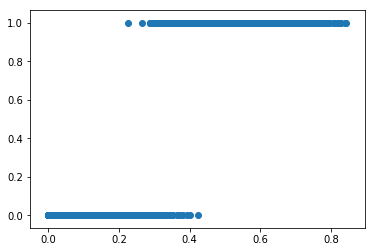

In [78]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(predictprobs[:,1], actual)